In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/Tweets.csv')


In [ ]:
#column data
df.columns


Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
df.head(6)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#missing values
print(df.isnull().sum())

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [ ]:
df.shape

(14640, 15)

In [ ]:
#has entity count
df['airline_sentiment'].value_counts()


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [ ]:
plot_size = plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.4
4.8


<Axes: ylabel='count'>

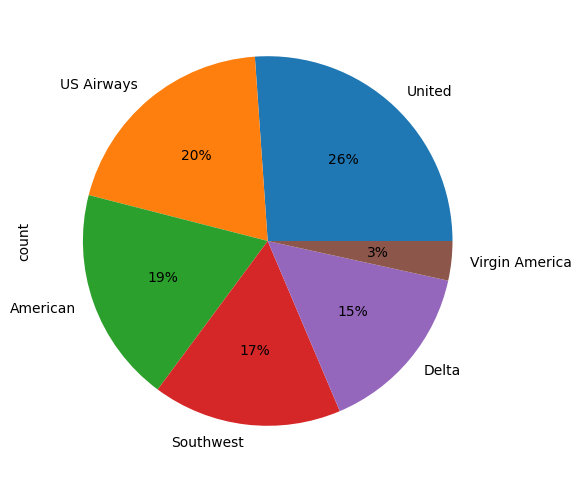

In [ ]:
df.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

<Axes: ylabel='count'>

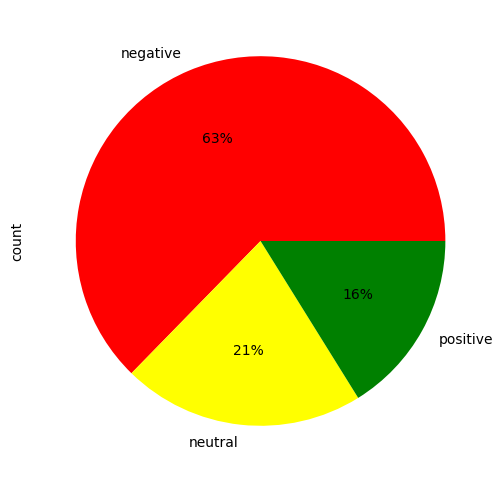

In [ ]:
df.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

<Axes: xlabel='airline'>

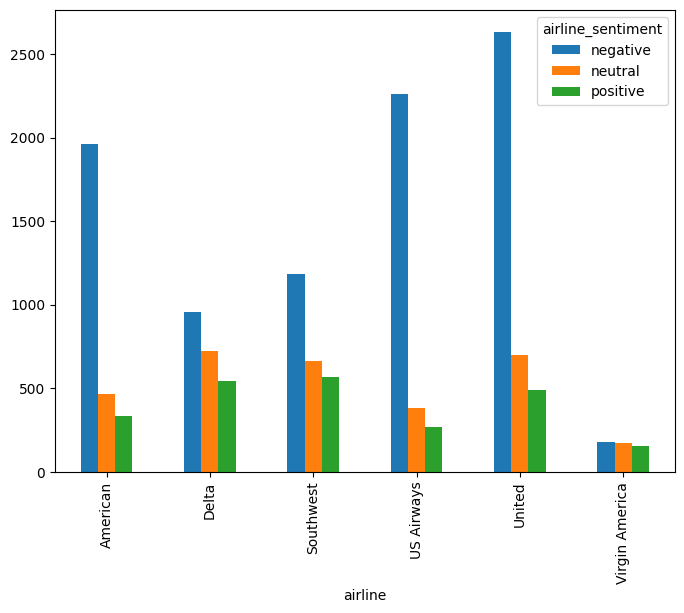

In [ ]:
airline_sentiment = df.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

<Axes: xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

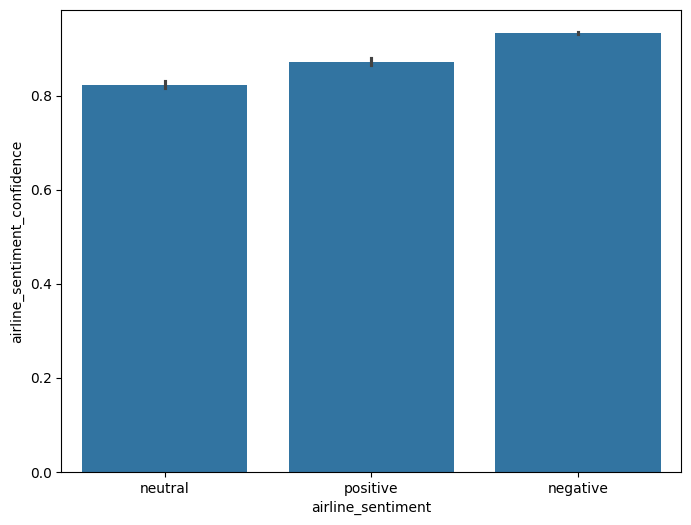

In [ ]:
import seaborn as sns

sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=df)


In [ ]:
features = df.iloc[:, 10].values
labels = df.iloc[:, 1].values


In [ ]:
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)


In [ ]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
##Stem the tweets and remove grammer oriented words from it
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in range(len(df)):
    rp = re.sub('[^a-zA-Z]'," ",df['text'][i])
    rp = rp.lower()
    rp = rp.split()
    rp = [ps.stem(word) for word in rp if not word in set(stopwords.words('english'))]


    rp = " ".join(rp)
    corpus.append(rp)

In [ ]:
corpus

['virginamerica dhepburn said',
 'virginamerica plu ad commerci experi tacki',
 'virginamerica today must mean need take anoth trip',
 'virginamerica realli aggress blast obnoxi entertain guest face amp littl recours',
 'virginamerica realli big bad thing',
 'virginamerica serious would pay flight seat play realli bad thing fli va',
 'virginamerica ye nearli everi time fli vx ear worm go away',
 'virginamerica realli miss prime opportun men without hat parodi http co mwpg grezp',
 'virginamerica well',
 'virginamerica amaz arriv hour earli good',
 'virginamerica know suicid second lead caus death among teen',
 'virginamerica lt pretti graphic much better minim iconographi',
 'virginamerica great deal alreadi think nd trip australia amp even gone st trip yet p',
 'virginamerica virginmedia fli fabul seduct sky u take stress away travel http co ahlxhhkiyn',
 'virginamerica thank',
 'virginamerica sfo pdx schedul still mia',
 'virginamerica excit first cross countri flight lax mco heard n

In [ ]:
# Convert the words into count vectors
from sklearn.feature_extraction.text import CountVectorizer  # Corrected class name
cv = CountVectorizer()  # Corrected class name
X = cv.fit_transform(corpus).toarray()

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
#Encode categorical variables

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df[['airline_sentiment']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

In [ ]:
#Train the model using naive bayes
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train,y_train)

MultinomialNB()

In [ ]:
#preidct the outomes
y_pred = model.predict(X_train)

In [ ]:
#Calculate the cross validation score
from sklearn.model_selection import cross_val_score
score = cross_val_score(model,X,y,cv=5)
print(score)

[0.72233607 0.73702186 0.65471311 0.75990437 0.6909153 ]


In [ ]:
model.score(X_test,y_test)

0.7711748633879781

In [ ]:
rf_model = RandomForestClassifier(random_state=0)

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
model.score(X_train,y_train)

0.8265881147540983

In [ ]:
y_pred_rf = rf_model.predict(X_test)

In [ ]:
import sklearn.model_selection as skms
from sklearn.metrics import classification_report

# Assuming you have already imported necessary libraries (e.g., pandas, numpy)
# and prepared your training and testing data (X_train, X_test, y_train, y_test)

# Perform cross-validation to get a more robust estimate of model performance
scores = skms.cross_val_score(rf_model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

# Train the Random Forest model on the entire training data
rf_model.fit(X_train, y_train)

# Get predictions on the testing data
y_pred = rf_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-validation scores: [0.76739223 0.75544174 0.75320239 0.76302306 0.75192143]
Average cross-validation score: 0.7581961713088352

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1889
           1       0.61      0.46      0.52       580
           2       0.77      0.61      0.68       459

    accuracy                           0.78      2928
   macro avg       0.73      0.66      0.69      2928
weighted avg       0.77      0.78      0.77      2928



<Axes: xlabel='airline_sentiment', ylabel='count'>

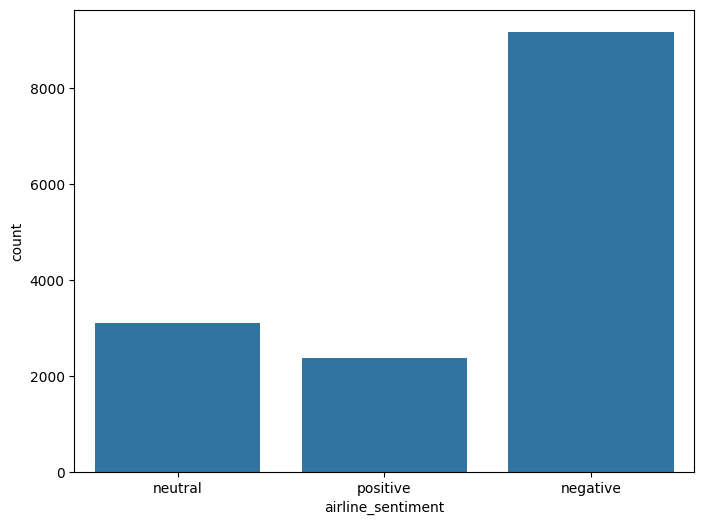

In [ ]:
#Countplot for sentiment
sns.countplot(data=df,x = 'airline_sentiment')